In [190]:
import pandas as pd
import numpy as np
import json
from tqdm.notebook import tqdm
tqdm.pandas()
import os
import re
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN

In [2]:
from langdetect import detect, DetectorFactory
DetectorFactory.seed = 0

In [3]:
#!python -m pip install pyaspeller
from pyaspeller import YandexSpeller

speller = YandexSpeller()

In [7]:
#тональность англ
from nltk.sentiment import SentimentIntensityAnalyzer
import nltk
nltk.downloader.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/tanya/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [21]:
sia = SentimentIntensityAnalyzer()

In [10]:
nltk.download('stopwords') 
stopwords_nltk = nltk.corpus.stopwords.words('russian') 
#лист русский стоп-слов 
stopwords_nltk_en = nltk.corpus.stopwords.words('english') 
stopwords_nltk.extend(stopwords_nltk_en)

[nltk_data] Downloading package stopwords to /home/tanya/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [12]:
#тональность рус
from dostoevsky.tokenization import RegexTokenizer
from dostoevsky.models import FastTextSocialNetworkModel
#!python3 -m dostoevsky download fasttext-social-network-model

tokenizer_d = RegexTokenizer()
model_d = FastTextSocialNetworkModel(tokenizer=tokenizer_d)

In [110]:
#тональность рус 0: NEUTRAL 1: POSITIVE 2: NEGATIVE
#from transformers import AutoModelForSequenceClassification
#from transformers import BertTokenizerFast
tokenizer_s = BertTokenizerFast.from_pretrained('blanchefort/rubert-base-cased-sentiment')
model_s = AutoModelForSequenceClassification.from_pretrained('blanchefort/rubert-base-cased-sentiment', return_dict=True)

In [143]:
def predict_sent(text):
    inputs = tokenizer_s(text, max_length=128, padding=True, truncation=True, return_tensors='pt')
    outputs = model_s(**inputs)
    predicted = torch.nn.functional.softmax(outputs.logits, dim=1)
    predicted = torch.argmax(predicted, dim=1).numpy()
    return predicted

In [153]:
predict_sent('интересующаяся')[0]

1

In [ ]:
#https://stackoverflow.com/questions/74586892/no-module-named-keras-saving-hdf5-format
from transformers import pipeline
model_p = pipeline(model="seara/rubert-tiny2-russian-sentiment")

In [148]:
#model_p("заинтересованная")[0]['label']

In [13]:
import spacy 
#!python -m spacy download ru_core_news_md 
activated = spacy.prefer_gpu() 
lemmatizer = spacy.load('ru_core_news_md', disable = ['parser', 'ner'])

2023-09-10 07:22:08.748207: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-10 07:22:09.437323: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2023-09-10 07:22:10.251825: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-09-10 07:22:10.252773: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA n

In [14]:
import torch
from transformers import AutoTokenizer, AutoModel

tokenizer_e = AutoTokenizer.from_pretrained("cointegrated/rubert-tiny")
model_e = AutoModel.from_pretrained("cointegrated/rubert-tiny")

Some weights of the model checkpoint at cointegrated/rubert-tiny were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [9]:
def lang_detect(s):
    # язык текста
    return detect(s)

In [170]:
def clean_text(s):
    # проверка орфографии яндекс спеллером и лемматизация
    s=re.sub(r"[^a-zA-Zа-яА-Я#]", " ", s)
    s = s.lower()
    s = speller.spelled(s)
    s = re.sub(" +", " ", s)
    text = " ".join([token.lemma_ for token in lemmatizer(s) if token.lemma_ not in stopwords_nltk])
    #if len(text) < 0:
    #    text=s
    return text

In [15]:
def get_embeding(s):
    # векторы
    embeding = embed_bert_cls(s, model_e, tokenizer_e)
    return embeding

In [121]:
def get_sentiment(lang, text):
    if lang=="ru":
        #score=model_d.predict([text], k = 1)
        #res = list(score[0].keys())[0]
        #res = model_p(text)[0]['label']
        #if res!='positive' or res!='negative':
            #res='neutral' #'skip'
        score = predict_sent(text)[0]
        if score == 1:
            res = 'positive'
        elif score == 2:
            res = 'negative'
        else:
            #0
            res = 'neutral'        
    else:
        score = sia.polarity_scores(text)
        score = sorted(score)[0]
        if score == 'pos':
            res = 'positive'
        elif score == 'neg':
            res = 'negative'
        else:
            #'neu','compound'
            res = 'neutral'
    return res

In [176]:
def embed_bert_cls(text, model, tokenizer):
    t = tokenizer(text, padding=True, truncation=True, return_tensors='pt')
    with torch.no_grad():
        model_output = model(**{k: v.to(model.device) for k, v in t.items()})
    embeddings = model_output.last_hidden_state[:, 0, :]
    embeddings = torch.nn.functional.normalize(embeddings)
    return embeddings[0].cpu().numpy()

In [241]:
def clustering(embeddings):
    #algo="dbscan" сам определяет количество классов, шум кластер=-1
    kmeans = DBSCAN(eps=0.5, min_samples=1, metric='euclidean') #'euclidean''cosine'
    kmeans.fit(embeddings)
    kmeans_labels = kmeans.labels_
    kmeans_top_texts = ' '

    return kmeans_labels

In [43]:
dirPath = r"labeled"
result = [f for f in os.listdir(dirPath) if os.path.isfile(os.path.join(dirPath, f))]
print(result)

['27599.json', '24948.json', '27497.json', '23570.json', '25005.json', '24521.json', '24446.json', '25785.json', '24749.json', '23764.json', '24335.json', '23486.json', '25728.json', '24727.json', '24378.json', '20398.json', '24519.json', '25599.json', '24631.json', '27601.json', '21756.json', '20799.json', '23097.json', '24949.json', '25318.json', '20139.json', '24379.json', '24738.json', '25317.json', '26608.json', '27598.json', '23422.json', '25246.json', '26204.json', '27543.json', '24719.json', '24334.json', '26901.json', '25723.json', '24376.json', '23433.json', '25695.json', '24270.json', '24308.json', '24689.json', '23765.json', '25708.json', '24268.json', '24743.json', '23465.json', '23379.json', '26594.json', '26985.json', '21584.json', '27600.json', '21718.json', '23023.json', '27128.json', '23507.json', '26111.json', '23423.json', '24682.json', '28567.json', '23516.json', '24599.json', '21819.json', '28463.json', '23239.json', '28158.json', '27501.json', '20785.json', '2473

In [56]:
cont = []
for fname in result:
    data = json.load(open('labeled/'+fname, encoding='utf-8-sig'))
    temp = pd.DataFrame(data['answers'])
    temp['question'] = data['question']
    temp['code'] = int(fname.split(".")[0])
    cont.append(temp)
    
data = pd.concat(cont)
data.reset_index(inplace=True, drop=True)

In [57]:
data['corrected']=data['corrected'].fillna(data['answer'])

In [58]:
data

,answer,count,cluster,sentiment,corrected,question,code
0,активность,1,активность,context sentiment,активность,Какие 3 информационные темы актуальны для моло...,27599
1,заинтересованная,1,заинтересованная,context sentiment,заинтересованная,Какие 3 информационные темы актуальны для моло...,27599
2,интересующаяся,1,интересующаяся,context sentiment,заинтересованная,Какие 3 информационные темы актуальны для моло...,27599
3,мотивация,8,мотивация,context sentiment,мотивация,Какие 3 информационные темы актуальны для моло...,27599
4,мотивация труда,2,мотивация труда,context sentiment,мотивация,Какие 3 информационные темы актуальны для моло...,27599
...,...,...,...,...,...,...,...
5234,чел-к с внутр потреб помогать,1,человек с внутренней потребностью помогать,neutrals,человек с внутренней потребностью помогать,Кто такой волонтер?,25706
5235,умеющий человек,1,умеющий человек,positives,умеющий человек,Кто такой волонтер?,25706
5236,человек с большим сердцем,1,человек с большим сердцем,positives,человек с большим сердцем,Кто такой волонтер?,25706
5237,человечный,1,человечный,positives,человечный,Кто такой волонтер?,25706


In [59]:
#data.to_csv("labeled.csv", index=False)

In [60]:
#язык
data["lang"] = data["question"].progress_apply(lambda x: lang_detect(x))

  0%|          | 0/5239 [00:00<?, ?it/s]

In [154]:
#тональность
data["sentiment1"] = data.progress_apply(lambda x: get_sentiment(x['lang'], x['answer']), axis=1)

  0%|          | 0/5239 [00:00<?, ?it/s]

In [171]:
#очистка текста
data["cleaned"] = data["answer"].progress_apply(lambda x: clean_text(x))

  0%|          | 0/5239 [00:00<?, ?it/s]

In [177]:
#векторы
data["embed"]=data["cleaned"].progress_apply(lambda x: get_embeding(x))

  0%|          | 0/5239 [00:00<?, ?it/s]

In [178]:
data

,answer,count,cluster,sentiment,corrected,question,code,lang,sentiment1,cleaned,embed
0,активность,1,активность,context sentiment,активность,Какие 3 информационные темы актуальны для моло...,27599,ru,neutral,активность,"[0.018481588, 0.0045122867, 0.043409396, -0.05..."
1,заинтересованная,1,заинтересованная,context sentiment,заинтересованная,Какие 3 информационные темы актуальны для моло...,27599,ru,negative,заинтересованный,"[-0.026877686, -0.01185091, 0.033654545, -0.04..."
2,интересующаяся,1,интересующаяся,context sentiment,заинтересованная,Какие 3 информационные темы актуальны для моло...,27599,ru,positive,интересующаяся,"[0.0011691105, -0.008040176, 0.068679765, -0.0..."
3,мотивация,8,мотивация,context sentiment,мотивация,Какие 3 информационные темы актуальны для моло...,27599,ru,neutral,мотивация,"[-0.012443379, -0.036504503, 0.03945215, -0.04..."
4,мотивация труда,2,мотивация труда,context sentiment,мотивация,Какие 3 информационные темы актуальны для моло...,27599,ru,neutral,мотивация труд,"[0.007301983, -0.03525315, 0.04429851, -0.0351..."
...,...,...,...,...,...,...,...,...,...,...,...
5234,чел-к с внутр потреб помогать,1,человек с внутренней потребностью помогать,neutrals,человек с внутренней потребностью помогать,Кто такой волонтер?,25706,ru,neutral,чел внутр потреб помогать,"[-0.017939746, 0.039575614, 0.09671054, -0.037..."
5235,умеющий человек,1,умеющий человек,positives,умеющий человек,Кто такой волонтер?,25706,ru,positive,уметь человек,"[-0.02216963, -0.0033337118, 0.019639445, -0.0..."
5236,человек с большим сердцем,1,человек с большим сердцем,positives,человек с большим сердцем,Кто такой волонтер?,25706,ru,neutral,человек больший сердце,"[-0.025635961, 0.039661497, 0.058777086, -0.09..."
5237,человечный,1,человечный,positives,человечный,Кто такой волонтер?,25706,ru,negative,человечный,"[-0.027404636, 0.016561264, 0.053755637, -0.06..."


Кластеры

In [245]:
codes = list(data['code'].unique())

In [251]:
clusters = []
for code in codes:
    temp=data[data['code']==code]
    embeddings=np.array(list(temp['embed']))
    kmeans_labels = clustering(embeddings)
    clusters.extend(list(kmeans_labels))
    
data['clusters'] = clusters

In [252]:
data

,answer,count,cluster,sentiment,corrected,question,code,lang,sentiment1,cleaned,embed,clusters
0,активность,1,активность,context sentiment,активность,Какие 3 информационные темы актуальны для моло...,27599,ru,neutral,активность,"[0.018481588, 0.0045122867, 0.043409396, -0.05...",0
1,заинтересованная,1,заинтересованная,context sentiment,заинтересованная,Какие 3 информационные темы актуальны для моло...,27599,ru,negative,заинтересованный,"[-0.026877686, -0.01185091, 0.033654545, -0.04...",0
2,интересующаяся,1,интересующаяся,context sentiment,заинтересованная,Какие 3 информационные темы актуальны для моло...,27599,ru,positive,интересующаяся,"[0.0011691105, -0.008040176, 0.068679765, -0.0...",0
3,мотивация,8,мотивация,context sentiment,мотивация,Какие 3 информационные темы актуальны для моло...,27599,ru,neutral,мотивация,"[-0.012443379, -0.036504503, 0.03945215, -0.04...",0
4,мотивация труда,2,мотивация труда,context sentiment,мотивация,Какие 3 информационные темы актуальны для моло...,27599,ru,neutral,мотивация труд,"[0.007301983, -0.03525315, 0.04429851, -0.0351...",0
...,...,...,...,...,...,...,...,...,...,...,...,...
5234,чел-к с внутр потреб помогать,1,человек с внутренней потребностью помогать,neutrals,человек с внутренней потребностью помогать,Кто такой волонтер?,25706,ru,neutral,чел внутр потреб помогать,"[-0.017939746, 0.039575614, 0.09671054, -0.037...",1
5235,умеющий человек,1,умеющий человек,positives,умеющий человек,Кто такой волонтер?,25706,ru,positive,уметь человек,"[-0.02216963, -0.0033337118, 0.019639445, -0.0...",1
5236,человек с большим сердцем,1,человек с большим сердцем,positives,человек с большим сердцем,Кто такой волонтер?,25706,ru,neutral,человек больший сердце,"[-0.025635961, 0.039661497, 0.058777086, -0.09...",10
5237,человечный,1,человечный,positives,человечный,Кто такой волонтер?,25706,ru,negative,человечный,"[-0.027404636, 0.016561264, 0.053755637, -0.06...",1


In [ ]:
#data.to_csv("labeled.csv", index=False)

Визулизация

In [35]:
codes = list(data['code'].unique())

In [36]:
codes[0]

27599

In [46]:
temp = data[data.code==codes[5]]
temp

,answer,count,cluster,sentiment,corrected,question,code
0,адаптация,2,адаптация,neutrals,адаптация,Какие проекты за рамками обозначенных направле...,24521
1,баланс работы и личной жизни,1,баланс работы и личной жизни,positives,баланс работы и личной жизни,Какие проекты за рамками обозначенных направле...,24521
2,безопасность,3,безопасность,positives,безопасность,Какие проекты за рамками обозначенных направле...,24521
3,безопасность нам её развивать,1,безопасность,positives,безопасность нам её развивать,Какие проекты за рамками обозначенных направле...,24521
4,культура безопасности,1,безопасность,positives,культура безопасности,Какие проекты за рамками обозначенных направле...,24521
5,бренд работодателя,1,бренд работодателя,neutrals,бренд работодателя,Какие проекты за рамками обозначенных направле...,24521
6,в связи с утечкой мозгов,1,в связи с утечкой мозгов,neutrals,в связи с утечкой мозгов,Какие проекты за рамками обозначенных направле...,24521
7,вовлечение в спорт,1,спорт,neutrals,вовлечение в спорт,Какие проекты за рамками обозначенных направле...,24521
8,корпоративный спорт,1,спорт,neutrals,корпоративный спорт,Какие проекты за рамками обозначенных направле...,24521
9,спорт,4,спорт,neutrals,спорт,Какие проекты за рамками обозначенных направле...,24521


In [50]:
temp.groupby(by=["sentiment"]).agg("sum")['count'].reset_index()

,sentiment,count
0,neutrals,53
1,positives,17


In [51]:
temp.groupby(by=["cluster"]).agg("sum")['count'].reset_index()

,cluster,count
0,адаптация,2
1,баланс работы и личной жизни,1
2,безопасность,5
3,бренд работодателя,1
4,в связи с утечкой мозгов,1
5,вовлеченность,1
6,волонтёрство,6
7,дебюрократизация,1
8,длительный туризм,1
9,донорство,1


In [38]:
import matplotlib.pyplot as plt

([<matplotlib.patches.Wedge at 0x7f849c34af70>,
 [Text(-0.7950743136073096, 0.7601689521690989, 'neutrals'),
  Text(0.7950742780212321, -0.7601689893892125, 'positives')])

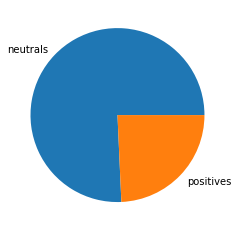

In [56]:
temp1 = temp.groupby(by=["sentiment"]).agg("sum")['count'].reset_index()
fig1, ax1 = plt.subplots()
ax1.pie(temp1['count'], labels=temp1['sentiment'])

In [ ]:
temp2 = temp.groupby(by=["cluster"]).agg("sum")['count'].reset_index()
temp2.sort_values(by=['count'], ascending=True, inplace=True)
fig2, ax2 = plt.subplots(figsize=(10, 8))
ax2.barh(temp2['cluster'][0:5], temp2['count'])

In [66]:
temp2.sort_values(by=['count'], ascending=False, inplace=True)